In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import seaborn as sns
from mpl_toolkits.axes_grid1 import inset_locator
import matplotlib.pyplot as plt
from matplotlib import colors
import shap
import pickle
import scipy.stats as stats

In [2]:
independent_features = ['BINGEING OF SESSIONS',
 'CONSTANCY OF CLICKS',
 'CONSTANCY OF SESSION LENGTH',
 'MEDIAN DIFF. BETWEEN ACTIVE DAYS',
 'MEDIAN NUMBER OF ACTIONS PER SESSION',
 'MEDIAN NUMBER OF ACTIVE DAYS PER WEEK',
 'MEDIAN SESSION DURATION',
 'PROPORTION OF ACTIVE DAYS',
 'PROPORTION OF FIRST-DAY-OF-WEEK ACTIVITY',
 'PROPORTION OF POSTS READ',
 'PROPORTION OF WEEKS WITH FIRST-DAY ACTIVITY',
 'REGULARITY OF SESSIONS',
 'TOTAL NUMBER OF CREATED POSTS',
 'TOTAL NUMBER OF SESSIONS',
 'TOTAL SESSIONS DURATION',
 'UNIFORMITY OF SESSIONS']

# Analysis parameter specification

In [3]:
year_start = '1819'
year_finish = '1920'
course_name = 'Global economics'
analysis_type = 'balanced'
exam_month = 'june'

In [4]:
def read_shaps_per_fold(course, model, year_start, year_finish):

    shap_importances_y1_per_fold = {}
    shap_importances_y2_per_fold=  {}
    shap_importances_y2_retrained_per_fold = {}
    shap_importances_y2_cv_per_fold = {}
    for i in range(10):

        shaps_fold = pd.read_excel(f'results final/{course} {year_start} vs. {year_finish} {analysis_type}/{course}_SHAP_scores_{model}_{year_start}_per_fold.xlsx', sheet_name=f'Sheet{i+1}', names = independent_features)
        shap_importances_y1_per_fold[i] = shaps_fold

        shaps_fold = pd.read_excel(f'results final/{course} {year_start} vs. {year_finish} {analysis_type}/{course}_SHAP_scores_{model}_{year_finish}_per_fold.xlsx', sheet_name=f'Sheet{i+1}', names = independent_features)
        shap_importances_y2_per_fold[i] = shaps_fold

        shaps_fold = pd.read_excel(f'results final/{course} {year_start} vs. {year_finish} {analysis_type}/{course}_SHAP_scores_{model}_{year_finish}_retrained_per_fold.xlsx', sheet_name=f'Sheet{i+1}', names = independent_features)
        shap_importances_y2_retrained_per_fold[i] = shaps_fold

        shaps_fold = pd.read_excel(f'results final/{course} {year_start} vs. {year_finish} {analysis_type}/{course}_SHAP_scores_{model}_{year_finish}_cv_per_fold.xlsx', sheet_name=f'Sheet{i+1}', names = independent_features)
        shap_importances_y2_cv_per_fold[i] = shaps_fold

    return shap_importances_y1_per_fold,shap_importances_y2_per_fold,shap_importances_y2_retrained_per_fold,shap_importances_y2_cv_per_fold

In [5]:
def shaps_per_fold(shaps_y1_per_fold, shaps_y2_per_fold,\
          shaps_y2_retrained_per_fold, shaps_y2_cv_per_fold, year_start, year_finish):
    
    shap_importances_y1_per_fold = {}
    shap_importances_y2_per_fold = {}
    shap_importances_y2_retrained_per_fold = {}
    shap_importances_y2_cv_per_fold = {}

    for i in range(10):
        resultX = pd.DataFrame(shaps_y1_per_fold[i], columns = independent_features)
        vals = np.abs(resultX.values).mean(0)
        shap_importance = pd.DataFrame(list(zip(independent_features, vals)),
                                        columns=['col_name','feature_importance_vals'])
        shap_importance.sort_values(by=['feature_importance_vals'],
                                    ascending=False, inplace=True)
        shap_importance['Rank'] = len(stats.rankdata(shap_importance['feature_importance_vals'], method='max')) \
            - stats.rankdata(shap_importance['feature_importance_vals'], method='max') + 1
        shap_importance['Type'] = f'Original model on {year_start}'
        shap_importances_y1_per_fold[i] = shap_importance


        resultX = pd.DataFrame(shaps_y2_per_fold[i], columns = independent_features)
        vals = np.abs(resultX.values).mean(0)
        shap_importance = pd.DataFrame(list(zip(independent_features, vals)),
                                        columns=['col_name','feature_importance_vals'])
        shap_importance.sort_values(by=['feature_importance_vals'],
                                    ascending=False, inplace=True)
        shap_importance['Rank'] = len(stats.rankdata(shap_importance['feature_importance_vals'], method='max')) \
            - stats.rankdata(shap_importance['feature_importance_vals'], method='max') + 1
        shap_importance['Type'] = f'Original model on {year_finish}'
        shap_importances_y2_per_fold[i] = shap_importance


        resultX = pd.DataFrame(shaps_y2_retrained_per_fold[i], columns = independent_features)
        vals = np.abs(resultX.values).mean(0)
        shap_importance = pd.DataFrame(list(zip(independent_features, vals)),
                                        columns=['col_name','feature_importance_vals'])
        shap_importance.sort_values(by=['feature_importance_vals'],
                                    ascending=False, inplace=True)
        shap_importance['Rank'] = len(stats.rankdata(shap_importance['feature_importance_vals'], method='max')) \
            - stats.rankdata(shap_importance['feature_importance_vals'], method='max') + 1
        shap_importance['Type'] = f'Retrained model on {year_finish}'
        shap_importances_y2_retrained_per_fold[i] = shap_importance


        resultX = pd.DataFrame(shaps_y2_cv_per_fold[i], columns = independent_features)
        vals = np.abs(resultX.values).mean(0)
        shap_importance = pd.DataFrame(list(zip(independent_features, vals)),
                                        columns=['col_name','feature_importance_vals'])
        shap_importance.sort_values(by=['feature_importance_vals'],
                                    ascending=False, inplace=True)
        shap_importance['Rank'] = len(stats.rankdata(shap_importance['feature_importance_vals'], method='max')) \
            - stats.rankdata(shap_importance['feature_importance_vals'], method='max') + 1
        shap_importance['Type'] = f'CV + Retrained model on {year_finish}'
        shap_importances_y2_cv_per_fold[i] = shap_importance

    return shap_importances_y1_per_fold, shap_importances_y2_per_fold,\
          shap_importances_y2_retrained_per_fold, shap_importances_y2_cv_per_fold

# Performance analysis

In [7]:
def wilcoxon_test(pre, post):
    test_results = stats.wilcoxon(pre, post)
    return test_results.statistic, test_results.pvalue

In [8]:
def friedman_test(nb_performance, rf_performance, lr_performance, svm_performance,
                   knn_performance,mlp_performance,xgb_performance,tab_performance):
    new_columns = ['Model AY T-1 on AY T-1', 'Model AY T-1 on AY T',
                               'Model AY T-1 retrained on AY T', 'Model AY T on AY T']
    nb_performance.columns = new_columns
    rf_performance.columns = new_columns
    lr_performance.columns = new_columns
    svm_performance.columns = new_columns
    knn_performance.columns = new_columns
    mlp_performance.columns = new_columns
    xgb_performance.columns = new_columns
    tab_performance.columns = new_columns

    df_for_test = pd.concat([pd.DataFrame(nb_performance.mean(), columns = ['NB']).transpose(),
           pd.DataFrame(rf_performance.mean(), columns = ['RF']).transpose(),
           pd.DataFrame(lr_performance.mean(), columns = ['LR']).transpose(),
           pd.DataFrame(svm_performance.mean(), columns = ['SVM']).transpose(),
           pd.DataFrame(knn_performance.mean(), columns = ['KNN']).transpose(),
           pd.DataFrame(mlp_performance.mean(), columns = ['MLP']).transpose(),
           pd.DataFrame(xgb_performance.mean(), columns = ['XGB']).transpose(),
           pd.DataFrame(tab_performance.mean(), columns = ['TAB']).transpose(),
           ])

    test_results = stats.friedmanchisquare(df_for_test['Model AY T-1 on AY T-1'].values,df_for_test['Model AY T-1 on AY T'].values,
                            df_for_test['Model AY T-1 retrained on AY T'].values,df_for_test['Model AY T on AY T'].values )
    return test_results.statistic, test_results.pvalue

In [9]:
def apply_test(outer_scores_y1, outer_scores_y2, outer_scores_y2_retrained, outer_scores_y2_cv, model):

    t_stat_diff_y2, pvalue_diff_y2 = wilcoxon_test(outer_scores_y1.values,outer_scores_y2.values)

    t_stat_diff_y2_retrained, pvalue_diff_y2_retrained = wilcoxon_test(outer_scores_y2.values, outer_scores_y2_retrained.values)

    t_stat_diff_y2_cv, pvalue_diff_y2_cv = wilcoxon_test(outer_scores_y2.values, outer_scores_y2_cv.values)
    return pd.DataFrame({'Model': [model],
             f'Model AY T-1 on AY T-1 vs.\n Model AY T-1 on AY T': [f'{round(t_stat_diff_y2,3)} ({round(pvalue_diff_y2,3)})'],
              f'Model AY T-1 on AY T vs.\n Model AY T-1 retrained\n on AY T': [f'{round(t_stat_diff_y2_retrained,3)} ({round(pvalue_diff_y2_retrained,3)})'],
              f'Model AY T-1 on AY T vs.\n Model AY T on AY T': [f'{round(t_stat_diff_y2_cv,3)} ({round(pvalue_diff_y2_cv,3)})']})

In [10]:
Model = 'NB'
nb_performance = pd.read_excel(f'results final/{course_name} {year_start} vs. {year_finish} {analysis_type}/{course_name}_{Model}_performance.xlsx',
                               index_col=0)
nb_outer_scores_y1 = nb_performance[f'{Model} {year_start}']
nb_outer_scores_y2 = nb_performance[f'{Model} {year_finish}']
nb_outer_scores_y2_retrained = nb_performance[f'{Model} {year_finish} retrained']
nb_outer_scores_y2_cv = nb_performance[f'{Model} {year_finish} cv']

Model = 'RF'
rf_performance = pd.read_excel(f'results final/{course_name} {year_start} vs. {year_finish} {analysis_type}/{course_name}_{Model}_performance.xlsx',
                               index_col=0)
rf_outer_scores_y1 = rf_performance[f'{Model} {year_start}']
rf_outer_scores_y2 = rf_performance[f'{Model} {year_finish}']
rf_outer_scores_y2_retrained = rf_performance[f'{Model} {year_finish} retrained']
rf_outer_scores_y2_cv = rf_performance[f'{Model} {year_finish} cv']

Model = 'LR'
lr_performance = pd.read_excel(f'results final/{course_name} {year_start} vs. {year_finish} {analysis_type}/{course_name}_{Model}_performance.xlsx',
                               index_col=0)
lr_outer_scores_y1 = lr_performance[f'{Model} {year_start}']
lr_outer_scores_y2 = lr_performance[f'{Model} {year_finish}']
lr_outer_scores_y2_retrained = lr_performance[f'{Model} {year_finish} retrained']
lr_outer_scores_y2_cv = lr_performance[f'{Model} {year_finish} cv']

Model = 'SVM'
svm_performance = pd.read_excel(f'results final/{course_name} {year_start} vs. {year_finish} {analysis_type}/{course_name}_{Model}_performance.xlsx',
                               index_col=0)
svm_outer_scores_y1 = svm_performance[f'{Model} {year_start}']
svm_outer_scores_y2 = svm_performance[f'{Model} {year_finish}']
svm_outer_scores_y2_retrained = svm_performance[f'{Model} {year_finish} retrained']
svm_outer_scores_y2_cv = svm_performance[f'{Model} {year_finish} cv']

Model = 'KNN'
knn_performance = pd.read_excel(f'results final/{course_name} {year_start} vs. {year_finish} {analysis_type}/{course_name}_{Model}_performance.xlsx',
                               index_col=0)
knn_outer_scores_y1 = knn_performance[f'{Model} {year_start}']
knn_outer_scores_y2 = knn_performance[f'{Model} {year_finish}']
knn_outer_scores_y2_retrained = knn_performance[f'{Model} {year_finish} retrained']
knn_outer_scores_y2_cv = knn_performance[f'{Model} {year_finish} cv']

Model = 'MLP'
mlp_performance = pd.read_excel(f'results final/{course_name} {year_start} vs. {year_finish} {analysis_type}/{course_name}_{Model}_performance.xlsx',
                               index_col=0)
mlp_outer_scores_y1 = mlp_performance[f'{Model} {year_start}']
mlp_outer_scores_y2 = mlp_performance[f'{Model} {year_finish}']
mlp_outer_scores_y2_retrained = mlp_performance[f'{Model} {year_finish} retrained']
mlp_outer_scores_y2_cv = mlp_performance[f'{Model} {year_finish} cv']

Model = 'XGB'
xgb_performance = pd.read_excel(f'results final/{course_name} {year_start} vs. {year_finish} {analysis_type}/{course_name}_{Model}_performance.xlsx',
                               index_col=0)
xgb_outer_scores_y1 = xgb_performance[f'{Model} {year_start}']
xgb_outer_scores_y2 = xgb_performance[f'{Model} {year_finish}']
xgb_outer_scores_y2_retrained = xgb_performance[f'{Model} {year_finish} retrained']
xgb_outer_scores_y2_cv = xgb_performance[f'{Model} {year_finish} cv']

Model = 'TAB'
tab_performance = pd.read_excel(f'results final/{course_name} {year_start} vs. {year_finish} {analysis_type}/{course_name}_{Model}_performance.xlsx',
                               index_col=0)
tab_outer_scores_y1 = tab_performance[f'{Model} {year_start}']
tab_outer_scores_y2 = tab_performance[f'{Model} {year_finish}']
tab_outer_scores_y2_retrained = tab_performance[f'{Model} {year_finish} retrained']
tab_outer_scores_y2_cv = tab_performance[f'{Model} {year_finish} cv']

In [11]:
test_results = pd.DataFrame()
for i in [[nb_outer_scores_y1, nb_outer_scores_y2, nb_outer_scores_y2_retrained, nb_outer_scores_y2_cv,
             'NB'],
             [rf_outer_scores_y1, rf_outer_scores_y2, rf_outer_scores_y2_retrained, rf_outer_scores_y2_cv,
             'RF'],
             [lr_outer_scores_y1, lr_outer_scores_y2, lr_outer_scores_y2_retrained, lr_outer_scores_y2_cv,
             'LR'],
             [svm_outer_scores_y1, svm_outer_scores_y2, svm_outer_scores_y2_retrained, svm_outer_scores_y2_cv,
             'SVM'],
             [knn_outer_scores_y1, knn_outer_scores_y2, knn_outer_scores_y2_retrained, knn_outer_scores_y2_cv,
             'KNN'],
             [mlp_outer_scores_y1, mlp_outer_scores_y2, mlp_outer_scores_y2_retrained, mlp_outer_scores_y2_cv,
             'MLP'],
             [xgb_outer_scores_y1, xgb_outer_scores_y2, xgb_outer_scores_y2_retrained, xgb_outer_scores_y2_cv,
             'XGB'],\
             [tab_outer_scores_y1, tab_outer_scores_y2, tab_outer_scores_y2_retrained, tab_outer_scores_y2_cv,
             'TAB']
             ]:
    test_results = pd.concat([test_results, apply_test(i[0], i[1], i[2], i[3],
             i[4])])
test_results = test_results.set_index('Model')

In [12]:
friedman_test(nb_performance, rf_performance, lr_performance, svm_performance,
                   knn_performance,mlp_performance,xgb_performance,tab_performance)

(20.549999999999983, 0.00013053916392333583)

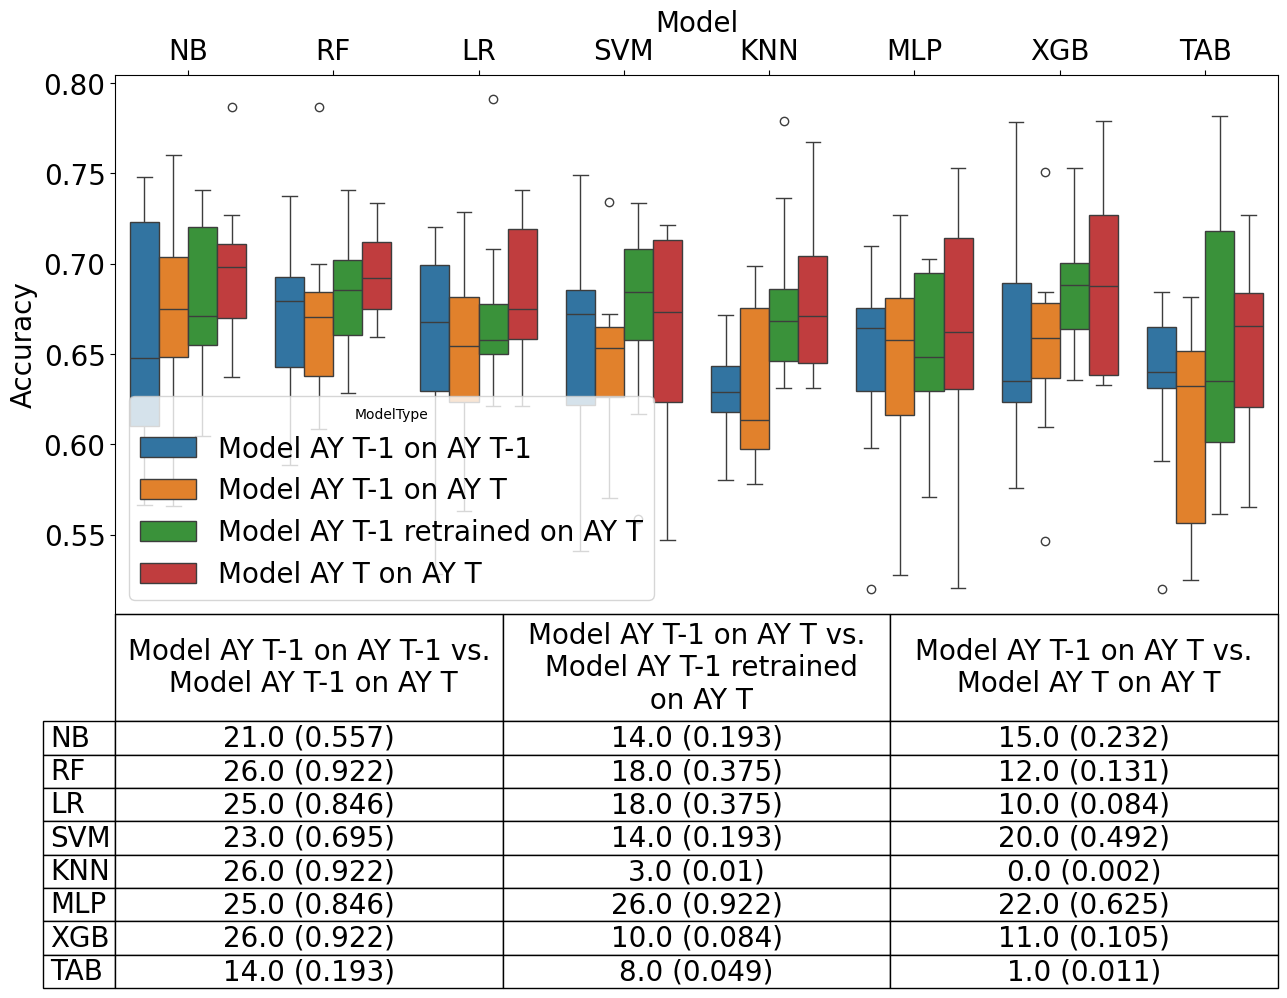

In [13]:
names = ['Model AY T-1 on AY T-1', 'Model AY T-1 on AY T', 'Model AY T-1 retrained on AY T', 'Model AY T on AY T', 'Name']
performance = pd.DataFrame(columns=names)

nb_performance['Name'] = 'NB'
nb_performance.columns = names
rf_performance['Name'] = 'RF'
rf_performance.columns = names
lr_performance['Name'] = 'LR'
lr_performance.columns = names
svm_performance['Name'] = 'SVM'
svm_performance.columns = names
knn_performance['Name'] = 'KNN'
knn_performance.columns = names
mlp_performance['Name'] = 'MLP'
mlp_performance.columns = names
xgb_performance['Name'] = 'XGB'
xgb_performance.columns = names
tab_performance['Name'] = 'TAB'
tab_performance.columns = names

performance = pd.concat([performance,nb_performance,rf_performance,lr_performance,
                         svm_performance,knn_performance,mlp_performance,
                         xgb_performance,
                        tab_performance
                         ])
performance = pd.melt(performance.reset_index(drop=True).reset_index(), id_vars=['index', 'Name'], var_name='ModelType', value_name='Value')

plt.figure(figsize=(15, 7))  

ax = sns.boxplot(x=performance['Name'], 
                 y=performance['Value'], 
                 hue=performance['ModelType'], 
                 palette='tab10')

ax.set_xlabel('Model', fontsize=20)  
ax.set_ylabel('Accuracy', fontsize=20)
ax.tick_params(axis='both', labelsize=20)
legend = plt.legend(title='ModelType', fontsize=20)

ax.xaxis.set_label_position('top') 
ax.xaxis.set_ticks_position('top')

table = plt.table(cellText=test_results.values,
                  rowLabels=test_results.index,
                  colLabels=test_results.columns,
                  loc='bottom',  
                  cellLoc='center')         
table.auto_set_font_size(False)

cellDict = table.get_celld()

for i in range(0,3):
    cellDict[(0,i)].set_height(.1)

table.set_fontsize(20)

axins = inset_locator.inset_axes(ax, width="30%", height="5%", loc='lower center')  # Adjust height
axins.axis('off')
table.scale(1, 2)
table.set_in_layout(True)
plt.show()

# Rank correlation

In [14]:
def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

def format_func(val):
    return '{:.2f}'.format(val)

def set_header_font():
    return [dict(selector="th:nth-child(3)",
                 props=[("font-size", "16pt")]),dict(selector="th:nth-child(2)",
                 props=[("font-size", "16pt")]),dict(selector="th:nth-child(4)",
                 props=[("font-size", "16pt")]),
                 dict(selector="th:nth-child(1)",
                 props=[("font-size", "16pt")]),]

In [15]:
def agreements_per_fold(shap_importances_y1_per_fold, shap_importances_y2_per_fold, shap_importances_y2_retrained_per_fold, shap_importances_y2_cv_per_fold, model_name, year_start, year_finish):

    agreements = pd.DataFrame()
    for i in range(10):
        shaps = pd.concat([shap_importances_y1_per_fold[i],shap_importances_y2_per_fold[i],
                      shap_importances_y2_retrained_per_fold[i], shap_importances_y2_cv_per_fold[i]])
        shaps['Model'] = model_name

        original_vs_new = stats.kendalltau(shaps[shaps['Type'] == f'Original model on {year_start}'].merge(shaps[shaps['Type'] == f'Original model on {year_finish}'], on = 'col_name').head(8)['Rank_x'],
                                        shaps[shaps['Type'] == f'Original model on {year_start}'].merge(shaps[shaps['Type'] == f'Original model on {year_finish}'], on = 'col_name').head(8)['Rank_y']).correlation
        original_vs_new_retrained = stats.kendalltau(shaps[shaps['Type'] == f'Original model on {year_start}'].merge(shaps[shaps['Type'] == f'Retrained model on {year_finish}'], on = 'col_name').head(8)['Rank_x'],
                                        shaps[shaps['Type'] == f'Original model on {year_start}'].merge(shaps[shaps['Type'] == f'Retrained model on {year_finish}'], on = 'col_name').head(8)['Rank_y']).correlation
        original_vs_new_cv = stats.kendalltau(shaps[shaps['Type'] == f'Original model on {year_start}'].merge(shaps[shaps['Type'] == f'CV + Retrained model on {year_finish}'], on = 'col_name').head(8)['Rank_x'],
                                        shaps[shaps['Type'] == f'Original model on {year_start}'].merge(shaps[shaps['Type'] == f'CV + Retrained model on {year_finish}'], on = 'col_name').head(8)['Rank_y']).correlation
       
        agreement_dict = {'Model': [model_name], 'Agreement: AY X vs. AY X+1': [original_vs_new],
                        'Agreement: AY X vs. AY X+1 retrained': [original_vs_new_retrained],
                            'Agreement: AY X vs. AY X+1 cross-validated + retrained': [original_vs_new_cv]}
        agreement_model = pd.DataFrame.from_dict(agreement_dict)
        agreements = pd.concat([agreements, agreement_model])    


    return agreements

In [16]:
def average_agreements(nb_agreements, rf_agreements, lr_agreements,
                        svm_agreements, knn_agreements, mlp_agreements,
                        xgb_agreements,
                        tab_agreements
                        ):
    nb = pd.DataFrame(nb_agreements[['Agreement: AY X vs. AY X+1',	'Agreement: AY X vs. AY X+1 retrained',	'Agreement: AY X vs. AY X+1 cross-validated + retrained']].mean(), columns=['NB'])
    rf = pd.DataFrame(rf_agreements[['Agreement: AY X vs. AY X+1',	'Agreement: AY X vs. AY X+1 retrained',	'Agreement: AY X vs. AY X+1 cross-validated + retrained']].mean(), columns=['RF'])
    lr = pd.DataFrame(lr_agreements[['Agreement: AY X vs. AY X+1',	'Agreement: AY X vs. AY X+1 retrained',	'Agreement: AY X vs. AY X+1 cross-validated + retrained']].mean(), columns=['LR'])
    svm = pd.DataFrame(svm_agreements[['Agreement: AY X vs. AY X+1',	'Agreement: AY X vs. AY X+1 retrained',	'Agreement: AY X vs. AY X+1 cross-validated + retrained']].mean(), columns=['SVM'])
    knn = pd.DataFrame(knn_agreements[['Agreement: AY X vs. AY X+1',	'Agreement: AY X vs. AY X+1 retrained',	'Agreement: AY X vs. AY X+1 cross-validated + retrained']].mean(), columns=['KNN'])
    mlp = pd.DataFrame(mlp_agreements[['Agreement: AY X vs. AY X+1',	'Agreement: AY X vs. AY X+1 retrained',	'Agreement: AY X vs. AY X+1 cross-validated + retrained']].mean(), columns=['MLP'])
    xgb = pd.DataFrame(xgb_agreements[['Agreement: AY X vs. AY X+1',	'Agreement: AY X vs. AY X+1 retrained',	'Agreement: AY X vs. AY X+1 cross-validated + retrained']].mean(), columns=['XGB'])
    tab = pd.DataFrame(tab_agreements[['Agreement: AY X vs. AY X+1',	'Agreement: AY X vs. AY X+1 retrained',	'Agreement: AY X vs. AY X+1 cross-validated + retrained']].mean(), columns=['TAB'])

    final = nb.merge(rf, left_index=True, right_index=True).merge(lr, left_index=True, right_index=True).merge(svm, 
                                                                                                               left_index=True, right_index=True).merge(knn, 
                                                                                                                                                        left_index=True, right_index=True).merge(mlp, left_index=True, right_index=True).merge(xgb, left_index=True, right_index=True).merge(tab, left_index=True, right_index=True)
    return final

In [17]:
independent_features_short = ['BINGEING OF SESSIONS',
 'CONSTANCY OF CLICKS',
 'CONSTANCY OF SESSION LENGTH',
 'MEDIAN DIFF. BETWEEN ACTIVE DAYS',
 'MEDIAN #ACTIONS PER SESSION',
 'MEDIAN #ACTIVE DAYS PER WEEK',
 'MEDIAN SESSION DURATION',
 'PROP. OF ACTIVE DAYS',
 'PROP. OF 1ST-DAY-OF-WEEK ACTIVITY',
 'PROP. OF POSTS READ',
 'PROP. OF WEEKS WITH 1ST-DAY ACTIVITY',
 'REGULARITY OF SESSIONS',
 'TOTAL #CREATED POSTS',
 'TOTAL #SESSIONS',
 'TOTAL SESSIONS DURATION',
 'UNIFORMITY OF SESSIONS']

In [18]:
column_names = ['Model AY X on AY X test data\n vs. Model AY X on AY X+1 test data',
                'Model AY X on AY X test data\n vs. Model AY X retrained on AY X+1 test data',
                'Model AY X on AY X test data\n vs. Model AY X+1 on AY X+1 test data']

In [19]:
nb_shaps_y1_per_fold, nb_shaps_y2_per_fold,\
          nb_shaps_y2_retrained_per_fold, nb_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'NB', year_start, year_finish)
rf_shaps_y1_per_fold, rf_shaps_y2_per_fold,\
          rf_shaps_y2_retrained_per_fold, rf_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'RF', year_start, year_finish)
lr_shaps_y1_per_fold, lr_shaps_y2_per_fold,\
          lr_shaps_y2_retrained_per_fold, lr_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'LR', year_start, year_finish)
svm_shaps_y1_per_fold, svm_shaps_y2_per_fold,\
          svm_shaps_y2_retrained_per_fold, svm_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'SVM', year_start, year_finish)
knn_shaps_y1_per_fold, knn_shaps_y2_per_fold,\
          knn_shaps_y2_retrained_per_fold, knn_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'KNN',  year_start, year_finish)
mlp_shaps_y1_per_fold, mlp_shaps_y2_per_fold,\
          mlp_shaps_y2_retrained_per_fold, mlp_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'MLP',  year_start, year_finish)
xgb_shaps_y1_per_fold, xgb_shaps_y2_per_fold,\
          xgb_shaps_y2_retrained_per_fold, xgb_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'XGB',  year_start, year_finish)
tab_shaps_y1_per_fold, tab_shaps_y2_per_fold,\
          tab_shaps_y2_retrained_per_fold, tab_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'TAB', year_start, year_finish)

In [20]:
nb_shap_importances_y1_per_fold, nb_shap_importances_y2_per_fold, nb_shap_importances_y2_retrained_per_fold, \
      nb_shap_importances_y2_cv_per_fold = shaps_per_fold(nb_shaps_y1_per_fold, nb_shaps_y2_per_fold,\
          nb_shaps_y2_retrained_per_fold, nb_shaps_y2_cv_per_fold, year_start, year_finish)

rf_shap_importances_y1_per_fold, rf_shap_importances_y2_per_fold, rf_shap_importances_y2_retrained_per_fold, \
      rf_shap_importances_y2_cv_per_fold = shaps_per_fold(rf_shaps_y1_per_fold, rf_shaps_y2_per_fold,\
          rf_shaps_y2_retrained_per_fold, rf_shaps_y2_cv_per_fold, year_start, year_finish)

lr_shap_importances_y1_per_fold, lr_shap_importances_y2_per_fold, lr_shap_importances_y2_retrained_per_fold, \
      lr_shap_importances_y2_cv_per_fold = shaps_per_fold(lr_shaps_y1_per_fold, lr_shaps_y2_per_fold,\
          lr_shaps_y2_retrained_per_fold, lr_shaps_y2_cv_per_fold, year_start, year_finish)

svm_shap_importances_y1_per_fold, svm_shap_importances_y2_per_fold, svm_shap_importances_y2_retrained_per_fold, \
      svm_shap_importances_y2_cv_per_fold = shaps_per_fold(svm_shaps_y1_per_fold, svm_shaps_y2_per_fold,\
          svm_shaps_y2_retrained_per_fold, svm_shaps_y2_cv_per_fold, year_start, year_finish)

knn_shap_importances_y1_per_fold, knn_shap_importances_y2_per_fold, knn_shap_importances_y2_retrained_per_fold, \
      knn_shap_importances_y2_cv_per_fold = shaps_per_fold(knn_shaps_y1_per_fold, knn_shaps_y2_per_fold,\
          knn_shaps_y2_retrained_per_fold, knn_shaps_y2_cv_per_fold, year_start, year_finish)

mlp_shap_importances_y1_per_fold, mlp_shap_importances_y2_per_fold, mlp_shap_importances_y2_retrained_per_fold, \
      mlp_shap_importances_y2_cv_per_fold = shaps_per_fold(mlp_shaps_y1_per_fold, mlp_shaps_y2_per_fold,\
          mlp_shaps_y2_retrained_per_fold, mlp_shaps_y2_cv_per_fold, year_start, year_finish)

xgb_shap_importances_y1_per_fold, xgb_shap_importances_y2_per_fold, xgb_shap_importances_y2_retrained_per_fold, \
      xgb_shap_importances_y2_cv_per_fold = shaps_per_fold(xgb_shaps_y1_per_fold, xgb_shaps_y2_per_fold,\
          xgb_shaps_y2_retrained_per_fold, xgb_shaps_y2_cv_per_fold, year_start, year_finish)

tab_shap_importances_y1_per_fold, tab_shap_importances_y2_per_fold, tab_shap_importances_y2_retrained_per_fold, \
      tab_shap_importances_y2_cv_per_fold = shaps_per_fold(tab_shaps_y1_per_fold, tab_shaps_y2_per_fold,\
          tab_shaps_y2_retrained_per_fold, tab_shaps_y2_cv_per_fold, year_start, year_finish)

In [21]:
nb_agreements = agreements_per_fold(nb_shap_importances_y1_per_fold, nb_shap_importances_y2_per_fold,
                                               nb_shap_importances_y2_retrained_per_fold, 
                                               nb_shap_importances_y2_cv_per_fold, 'NB', year_start, year_finish)
rf_agreements = agreements_per_fold(rf_shap_importances_y1_per_fold, rf_shap_importances_y2_per_fold,
                                               rf_shap_importances_y2_retrained_per_fold,
                                                 rf_shap_importances_y2_cv_per_fold, 'RF', year_start, year_finish)
lr_agreements = agreements_per_fold(lr_shap_importances_y1_per_fold, lr_shap_importances_y2_per_fold,
                                               lr_shap_importances_y2_retrained_per_fold,
                                                 lr_shap_importances_y2_cv_per_fold, 'LR', year_start, year_finish)
svm_agreements = agreements_per_fold(svm_shap_importances_y1_per_fold, svm_shap_importances_y2_per_fold,
                                                svm_shap_importances_y2_retrained_per_fold,
                                                  svm_shap_importances_y2_cv_per_fold, 'SVM', year_start, year_finish)
knn_agreements = agreements_per_fold(knn_shap_importances_y1_per_fold, knn_shap_importances_y2_per_fold,
                                                knn_shap_importances_y2_retrained_per_fold,
                                                  knn_shap_importances_y2_cv_per_fold, 'KNN', year_start, year_finish)
mlp_agreements = agreements_per_fold(mlp_shap_importances_y1_per_fold, mlp_shap_importances_y2_per_fold,
                                                mlp_shap_importances_y2_retrained_per_fold,
                                                  mlp_shap_importances_y2_cv_per_fold, 'MLP', year_start, year_finish)
xgb_agreements = agreements_per_fold(xgb_shap_importances_y1_per_fold, xgb_shap_importances_y2_per_fold,
                                                xgb_shap_importances_y2_retrained_per_fold,
                                                  xgb_shap_importances_y2_cv_per_fold, 'XGB', year_start, year_finish)
tab_agreements = agreements_per_fold(tab_shap_importances_y1_per_fold, tab_shap_importances_y2_per_fold,
                                                tab_shap_importances_y2_retrained_per_fold,
                                                  tab_shap_importances_y2_cv_per_fold, 'TAB', year_start, year_finish)

In [22]:
agreements = average_agreements(nb_agreements, rf_agreements, lr_agreements,
                                       svm_agreements, knn_agreements, mlp_agreements,
                                       xgb_agreements, 
                                    tab_agreements
                                           )
agreements = agreements.transpose()
agreements.index.name = 'Model'
agreements.columns = column_names

agreements.style.format(format_func).apply(background_gradient,
               cmap='PuBu',
               m=agreements.min().min(),
               M=agreements.max().max(),
               low=0,
               high=0.2).set_properties(**{
    'font-size': '18pt',
}).set_table_styles(set_header_font())

,Model AY X on AY X test data vs. Model AY X on AY X+1 test data,Model AY X on AY X test data vs. Model AY X retrained on AY X+1 test data,Model AY X on AY X test data vs. Model AY X+1 on AY X+1 test data
Model,,,
NB,0.66,0.50,0.33
RF,0.89,0.47,0.35
LR,0.65,0.57,0.29
SVM,0.77,0.36,0.41
KNN,0.86,0.66,0.61
MLP,0.76,0.67,0.49
XGB,0.66,0.39,0.35
TAB,0.65,0.24,0.32


In [ ]:
agreements.to_excel(f'metrics final/Rank correlation {course_name} {year_start} vs. {year_finish}.xlsx')

# Feature agreement

In [24]:
def feature_agreements_per_fold(shap_importances_y1_per_fold, shap_importances_y2_per_fold,
                                 shap_importances_y2_retrained_per_fold, shap_importances_y2_cv_per_fold, 
                                 model_name, year_start, year_finish):

    agreements = pd.DataFrame()

    for i in range(10):
        shaps = pd.concat([shap_importances_y1_per_fold[i],shap_importances_y2_per_fold[i],
                        shap_importances_y2_retrained_per_fold[i], shap_importances_y2_cv_per_fold[i]])
        shaps['Model'] = model_name

        original_vs_new = len(set(shaps[shaps['Type']
                                         == f'Original model on {year_start}'].head(8)['col_name']).intersection(shaps[shaps['Type'] 
                                                                                                                       == f'Original model on {year_finish}'].head(8)['col_name']))/8
        
        original_vs_new_retrained = len(set(shaps[shaps['Type'] 
                                                  == f'Original model on {year_start}'].head(8)['col_name']).intersection(shaps[shaps['Type'] 
                                                                                                                                == f'Retrained model on {year_finish}'].head(8)['col_name']))/8 

        original_vs_new_cv = len(set(shaps[shaps['Type'] 
                                           == f'Original model on {year_start}'].head(8)['col_name']).intersection(shaps[shaps['Type'] 
                                                                                                                         == f'CV + Retrained model on {year_finish}'].head(8)['col_name']))/8
        
        agreement_dict = {'Model': [model_name], 'Agreement: AY X vs. AY X+1': [original_vs_new],
                        'Agreement: AY X vs. AY X+1 retrained': [original_vs_new_retrained],
                            'Agreement: AY X vs. AY X+1 cross-validated + retrained': [original_vs_new_cv]}
        agreement_model = pd.DataFrame.from_dict(agreement_dict)
        agreements = pd.concat([agreements, agreement_model])    
        
    return agreements

In [25]:
nb_feature_agreements = feature_agreements_per_fold(nb_shap_importances_y1_per_fold, nb_shap_importances_y2_per_fold,
                                                               nb_shap_importances_y2_retrained_per_fold, nb_shap_importances_y2_cv_per_fold,
                                                                 'NB', year_start, year_finish)
rf_feature_agreements = feature_agreements_per_fold(rf_shap_importances_y1_per_fold, rf_shap_importances_y2_per_fold,
                                                               rf_shap_importances_y2_retrained_per_fold, rf_shap_importances_y2_cv_per_fold,
                                                                 'RF', year_start, year_finish)
lr_feature_agreements = feature_agreements_per_fold(lr_shap_importances_y1_per_fold, lr_shap_importances_y2_per_fold,
                                                               lr_shap_importances_y2_retrained_per_fold, lr_shap_importances_y2_cv_per_fold, 
                                                               'LR', year_start, year_finish)
svm_feature_agreements = feature_agreements_per_fold(svm_shap_importances_y1_per_fold, svm_shap_importances_y2_per_fold,
                                                                svm_shap_importances_y2_retrained_per_fold, svm_shap_importances_y2_cv_per_fold,
                                                                  'SVM', year_start, year_finish)
knn_feature_agreements = feature_agreements_per_fold(knn_shap_importances_y1_per_fold, knn_shap_importances_y2_per_fold,
                                                                knn_shap_importances_y2_retrained_per_fold, knn_shap_importances_y2_cv_per_fold,
                                                                  'KNN', year_start, year_finish)
mlp_feature_agreements = feature_agreements_per_fold(mlp_shap_importances_y1_per_fold, mlp_shap_importances_y2_per_fold,
                                                                mlp_shap_importances_y2_retrained_per_fold, mlp_shap_importances_y2_cv_per_fold,
                                                                  'MLP', year_start, year_finish)
xgb_feature_agreements = feature_agreements_per_fold(xgb_shap_importances_y1_per_fold, xgb_shap_importances_y2_per_fold,
                                                                xgb_shap_importances_y2_retrained_per_fold, xgb_shap_importances_y2_cv_per_fold,
                                                                  'XGB', year_start, year_finish)
tab_feature_agreements = feature_agreements_per_fold(tab_shap_importances_y1_per_fold, tab_shap_importances_y2_per_fold,
                                                                tab_shap_importances_y2_retrained_per_fold, tab_shap_importances_y2_cv_per_fold,
                                                                  'TAB', year_start, year_finish)

In [26]:
feature_agreements = average_agreements(nb_feature_agreements, rf_feature_agreements, lr_feature_agreements,
                                           svm_feature_agreements, knn_feature_agreements, mlp_feature_agreements, xgb_feature_agreements, 
                                           tab_feature_agreements
                                           )
feature_agreements = feature_agreements.transpose()
feature_agreements.index.name = 'Model'
feature_agreements.columns = column_names

In [27]:
feature_agreements.style.format(format_func).apply(background_gradient,
               cmap='PuBu',
               m=feature_agreements.min().min(),
               M=feature_agreements.max().max(),
               low=0,
               high=0.2).set_properties(**{
    'font-size': '18pt',
}).set_table_styles(set_header_font())

,Model AY X on AY X test data vs. Model AY X on AY X+1 test data,Model AY X on AY X test data vs. Model AY X retrained on AY X+1 test data,Model AY X on AY X test data vs. Model AY X+1 on AY X+1 test data
Model,,,
NB,0.95,0.84,0.70
RF,0.93,0.81,0.78
LR,0.89,0.75,0.68
SVM,0.93,0.68,0.69
KNN,0.89,0.81,0.79
MLP,0.89,0.81,0.68
XGB,0.88,0.76,0.74
TAB,0.84,0.59,0.69


In [ ]:
feature_agreements.to_excel(f'metrics final/Feature agreements {course_name} {year_start} vs. {year_finish}.xlsx')

# Rank agreement

In [28]:
def rank_agreements_per_fold(shap_importances_y1_per_fold, shap_importances_y2_per_fold,
                                 shap_importances_y2_retrained_per_fold, shap_importances_y2_cv_per_fold, 
                                 model_name):
    agreements = pd.DataFrame()
    for i in range(10):
        merged_df = shap_importances_y1_per_fold[i].merge(shap_importances_y2_per_fold[i],
                                                        on = 'col_name', suffixes=('_df1', '_df2'))
        topN_df = merged_df.head(8)
        original_vs_new = len(topN_df[topN_df['Rank_df1'] == topN_df['Rank_df2']])/8
                                      
        merged_df = shap_importances_y1_per_fold[i].merge(shap_importances_y2_retrained_per_fold[i],
                                                        on = 'col_name', suffixes=('_df1', '_df2'))
        topN_df = merged_df.head(8)
        original_vs_new_retrained = len(topN_df[topN_df['Rank_df1'] == topN_df['Rank_df2']])/8

        merged_df = shap_importances_y1_per_fold[i].merge(shap_importances_y2_cv_per_fold[i],
                                                        on = 'col_name', suffixes=('_df1', '_df2'))
        topN_df = merged_df.head(8)
        original_vs_new_cv = len(topN_df[topN_df['Rank_df1'] == topN_df['Rank_df2']])/8

        agreement_dict = {'Model': [model_name], 'Agreement: AY X vs. AY X+1': [original_vs_new],
                        'Agreement: AY X vs. AY X+1 retrained': [original_vs_new_retrained],
                            'Agreement: AY X vs. AY X+1 cross-validated + retrained': [original_vs_new_cv]}
        agreement_model = pd.DataFrame.from_dict(agreement_dict)
        agreements = pd.concat([agreements, agreement_model])    
        
    return agreements

In [29]:
nb_rank_agreements = rank_agreements_per_fold(nb_shap_importances_y1_per_fold, nb_shap_importances_y2_per_fold,
                                                               nb_shap_importances_y2_retrained_per_fold, nb_shap_importances_y2_cv_per_fold,
                                                                 'NB')
rf_rank_agreements = rank_agreements_per_fold(rf_shap_importances_y1_per_fold, rf_shap_importances_y2_per_fold,
                                                               rf_shap_importances_y2_retrained_per_fold, rf_shap_importances_y2_cv_per_fold,
                                                                 'RF')
lr_rank_agreements = rank_agreements_per_fold(lr_shap_importances_y1_per_fold, lr_shap_importances_y2_per_fold,
                                                               lr_shap_importances_y2_retrained_per_fold, lr_shap_importances_y2_cv_per_fold, 
                                                               'LR')
svm_rank_agreements = rank_agreements_per_fold(svm_shap_importances_y1_per_fold, svm_shap_importances_y2_per_fold,
                                                                svm_shap_importances_y2_retrained_per_fold, svm_shap_importances_y2_cv_per_fold,
                                                                  'SVM')
knn_rank_agreements = rank_agreements_per_fold(knn_shap_importances_y1_per_fold, knn_shap_importances_y2_per_fold,
                                                                knn_shap_importances_y2_retrained_per_fold, knn_shap_importances_y2_cv_per_fold,
                                                                  'KNN')
mlp_rank_agreements = rank_agreements_per_fold(mlp_shap_importances_y1_per_fold, mlp_shap_importances_y2_per_fold,
                                                                mlp_shap_importances_y2_retrained_per_fold, mlp_shap_importances_y2_cv_per_fold,
                                                                  'MLP')
xgb_rank_agreements = rank_agreements_per_fold(xgb_shap_importances_y1_per_fold, xgb_shap_importances_y2_per_fold,
                                                                xgb_shap_importances_y2_retrained_per_fold, xgb_shap_importances_y2_cv_per_fold,
                                                                  'XGB')
tab_rank_agreements = rank_agreements_per_fold(tab_shap_importances_y1_per_fold, tab_shap_importances_y2_per_fold,
                                                                tab_shap_importances_y2_retrained_per_fold, tab_shap_importances_y2_cv_per_fold,
                                                                  'TAB')

In [30]:
rank_agreements = average_agreements(nb_rank_agreements, rf_rank_agreements, lr_rank_agreements,
                                           svm_rank_agreements, knn_rank_agreements, mlp_rank_agreements,
                                           xgb_rank_agreements, 
                                           tab_rank_agreements
                                           )
rank_agreements = rank_agreements.transpose()
rank_agreements.index.name = 'Model'
rank_agreements.columns = column_names

In [31]:
rank_agreements.style.format(format_func).apply(background_gradient,
               cmap='PuBu',
               m=rank_agreements.min().min(),
               M=rank_agreements.max().max(),
               low=0,
               high=0.2).set_properties(**{
    'font-size': '18pt',
}).set_table_styles(set_header_font())

,Model AY X on AY X test data vs. Model AY X on AY X+1 test data,Model AY X on AY X test data vs. Model AY X retrained on AY X+1 test data,Model AY X on AY X test data vs. Model AY X+1 on AY X+1 test data
Model,,,
NB,0.51,0.36,0.24
RF,0.64,0.26,0.23
LR,0.39,0.33,0.23
SVM,0.50,0.23,0.12
KNN,0.59,0.29,0.33
MLP,0.44,0.38,0.26
XGB,0.36,0.19,0.21
TAB,0.35,0.16,0.16


In [ ]:
rank_agreements.to_excel(f'metrics final/Rank agreements {course_name} {year_start} vs. {year_finish}.xlsx')

# Stable features

In [32]:
def rank_visualize(shap_importances_y1_per_fold,shap_importances_y2_per_fold,
                   shap_importances_y2_retrained_per_fold,shap_importances_y2_cv_per_fold, year_start, year_finish):
    combined_df = pd.concat(shap_importances_y1_per_fold.values(), ignore_index=True)
    average_rank_y1 = combined_df.groupby("col_name")["Rank"]
    average_rank_y1 = average_rank_y1.rename(columns = {'Rank':f'Rank_{year_start}'})

    combined_df = pd.concat(shap_importances_y2_per_fold.values(), ignore_index=True)
    average_rank_y2 = combined_df.groupby("col_name")["Rank"]
    average_rank_y2 = average_rank_y2.rename(columns = {'Rank':f'Rank_{year_finish}'})

    combined_df = pd.concat(shap_importances_y2_retrained_per_fold.values(), ignore_index=True)
    average_rank_y2_retrained = combined_df.groupby("col_name")["Rank"]
    average_rank_y2_retrained = average_rank_y2_retrained.rename(columns = {'Rank':f'Rank_{year_finish}_retrained'})

    combined_df = pd.concat(shap_importances_y2_cv_per_fold.values(), ignore_index=True)
    average_rank_y2_cv = combined_df.groupby("col_name")["Rank"]
    average_rank_y2_cv = average_rank_y2_cv.rename(columns = {'Rank':f'Rank_{year_finish}_cv'})

    average_rank_y1_y2 = average_rank_y1.merge(average_rank_y2).merge(average_rank_y2_retrained).merge(average_rank_y2_cv)
    average_rank_y1_y2 = average_rank_y1_y2.set_index('col_name')
    average_rank_y1_y2 = average_rank_y1_y2.transpose()

    return average_rank_y1_y2

In [33]:
def stable_features(shap_importances_y1_per_fold, shap_importances_y2_per_fold, shap_importances_y2_retrained_per_fold, \
      shap_importances_y2_cv_per_fold ):
    feature_counts_y1 = {}
    for i in shap_importances_y1_per_fold:
        top_8 = shap_importances_y1_per_fold[i].head(8)['col_name'].values
        for feature in set(top_8):
            if feature in feature_counts_y1:
                feature_counts_y1[feature] += 1
            else:
                feature_counts_y1[feature] = 1
    feature_counts_y1 = {feature: count for feature, count in feature_counts_y1.items() if count >= 8}
                
    feature_counts_y2 = {}
    for i in shap_importances_y2_per_fold:
        top_8 = shap_importances_y2_per_fold[i].head(8)['col_name'].values
        for feature in set(top_8):
            if feature in feature_counts_y2:
                feature_counts_y2[feature] += 1
            else:
                feature_counts_y2[feature] = 1            
    feature_counts_y2 = {feature: count for feature, count in feature_counts_y2.items() if count >= 8}

    feature_counts_y2_retrained = {}
    for i in shap_importances_y2_retrained_per_fold:
        top_8 = shap_importances_y2_retrained_per_fold[i].head(8)['col_name'].values
        for feature in set(top_8):
            if feature in feature_counts_y2_retrained:
                feature_counts_y2_retrained[feature] += 1
            else:
                feature_counts_y2_retrained[feature] = 1            
    feature_counts_y2_retrained = {feature: count for feature, count in feature_counts_y2_retrained.items() if count >= 8}

    feature_counts_y2_cv = {}
    for i in shap_importances_y2_cv_per_fold:
        top_8 = shap_importances_y2_cv_per_fold[i].head(8)['col_name'].values
        for feature in set(top_8):
            if feature in feature_counts_y2_cv:
                feature_counts_y2_cv[feature] += 1
            else:
                feature_counts_y2_cv[feature] = 1            
    feature_counts_y2_cv = {feature: count for feature, count in feature_counts_y2_cv.items() if count >= 8}

    return set(feature_counts_y1.keys()), set(feature_counts_y2.keys()),\
                set(feature_counts_y2_retrained.keys()), set(feature_counts_y2_cv.keys())

In [34]:
nb_shaps_y1_per_fold, nb_shaps_y2_per_fold,\
          nb_shaps_y2_retrained_per_fold, nb_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'NB', year_start, year_finish)
rf_shaps_y1_per_fold, rf_shaps_y2_per_fold,\
          rf_shaps_y2_retrained_per_fold, rf_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'RF', year_start, year_finish)
lr_shaps_y1_per_fold, lr_shaps_y2_per_fold,\
          lr_shaps_y2_retrained_per_fold, lr_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'LR', year_start, year_finish)
svm_shaps_y1_per_fold, svm_shaps_y2_per_fold,\
          svm_shaps_y2_retrained_per_fold, svm_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'SVM', year_start, year_finish)
knn_shaps_y1_per_fold, knn_shaps_y2_per_fold,\
          knn_shaps_y2_retrained_per_fold, knn_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'KNN', year_start, year_finish)
mlp_shaps_y1_per_fold, mlp_shaps_y2_per_fold,\
          mlp_shaps_y2_retrained_per_fold, mlp_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'MLP', year_start, year_finish)
xgb_shaps_y1_per_fold, xgb_shaps_y2_per_fold,\
          xgb_shaps_y2_retrained_per_fold, xgb_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'XGB', year_start, year_finish)
tab_shaps_y1_per_fold, tab_shaps_y2_per_fold,\
          tab_shaps_y2_retrained_per_fold, tab_shaps_y2_cv_per_fold = read_shaps_per_fold(course_name, 'TAB', year_start, year_finish)

In [35]:
nb_shap_importances_y1_per_fold, nb_shap_importances_y2_per_fold, nb_shap_importances_y2_retrained_per_fold, \
      nb_shap_importances_y2_cv_per_fold = shaps_per_fold(nb_shaps_y1_per_fold, nb_shaps_y2_per_fold,\
          nb_shaps_y2_retrained_per_fold, nb_shaps_y2_cv_per_fold, year_start, year_finish)

rf_shap_importances_y1_per_fold, rf_shap_importances_y2_per_fold, rf_shap_importances_y2_retrained_per_fold, \
      rf_shap_importances_y2_cv_per_fold = shaps_per_fold(rf_shaps_y1_per_fold, rf_shaps_y2_per_fold,\
          rf_shaps_y2_retrained_per_fold, rf_shaps_y2_cv_per_fold, year_start, year_finish)

lr_shap_importances_y1_per_fold, lr_shap_importances_y2_per_fold, lr_shap_importances_y2_retrained_per_fold, \
      lr_shap_importances_y2_cv_per_fold = shaps_per_fold(lr_shaps_y1_per_fold, lr_shaps_y2_per_fold,\
          lr_shaps_y2_retrained_per_fold, lr_shaps_y2_cv_per_fold, year_start, year_finish)

svm_shap_importances_y1_per_fold, svm_shap_importances_y2_per_fold, svm_shap_importances_y2_retrained_per_fold, \
      svm_shap_importances_y2_cv_per_fold = shaps_per_fold(svm_shaps_y1_per_fold, svm_shaps_y2_per_fold,\
          svm_shaps_y2_retrained_per_fold, svm_shaps_y2_cv_per_fold, year_start, year_finish)

knn_shap_importances_y1_per_fold, knn_shap_importances_y2_per_fold, knn_shap_importances_y2_retrained_per_fold, \
      knn_shap_importances_y2_cv_per_fold = shaps_per_fold(knn_shaps_y1_per_fold, knn_shaps_y2_per_fold,\
          knn_shaps_y2_retrained_per_fold, knn_shaps_y2_cv_per_fold, year_start, year_finish)

mlp_shap_importances_y1_per_fold, mlp_shap_importances_y2_per_fold, mlp_shap_importances_y2_retrained_per_fold, \
      mlp_shap_importances_y2_cv_per_fold = shaps_per_fold(mlp_shaps_y1_per_fold, mlp_shaps_y2_per_fold,\
          mlp_shaps_y2_retrained_per_fold, mlp_shaps_y2_cv_per_fold, year_start, year_finish)

xgb_shap_importances_y1_per_fold, xgb_shap_importances_y2_per_fold, xgb_shap_importances_y2_retrained_per_fold, \
      xgb_shap_importances_y2_cv_per_fold = shaps_per_fold(xgb_shaps_y1_per_fold, xgb_shaps_y2_per_fold,\
          xgb_shaps_y2_retrained_per_fold, xgb_shaps_y2_cv_per_fold, year_start, year_finish)

tab_shap_importances_y1_per_fold, tab_shap_importances_y2_per_fold, tab_shap_importances_y2_retrained_per_fold, \
      tab_shap_importances_y2_cv_per_fold = shaps_per_fold(tab_shaps_y1_per_fold, tab_shaps_y2_per_fold,\
          tab_shaps_y2_retrained_per_fold, tab_shaps_y2_cv_per_fold, year_start, year_finish)

In [36]:
nb_feature_counts_y1, nb_feature_counts_y2, nb_feature_counts_y2_retrained, nb_feature_counts_y2_cv = stable_features(nb_shap_importances_y1_per_fold,\
                                                                                                           nb_shap_importances_y2_per_fold,\
                                                                                                             nb_shap_importances_y2_retrained_per_fold, \
                                                                                                                nb_shap_importances_y2_cv_per_fold )
nb_top_set = nb_feature_counts_y1.intersection(nb_feature_counts_y2).intersection(nb_feature_counts_y2_retrained).intersection(nb_feature_counts_y2_cv)

rf_feature_counts_y1, rf_feature_counts_y2, rf_feature_counts_y2_retrained, rf_feature_counts_y2_cv = stable_features(rf_shap_importances_y1_per_fold,\
                                                                                                           rf_shap_importances_y2_per_fold,\
                                                                                                             rf_shap_importances_y2_retrained_per_fold, \
                                                                                                                rf_shap_importances_y2_cv_per_fold )
rf_top_set = rf_feature_counts_y1.intersection(rf_feature_counts_y2).intersection(rf_feature_counts_y2_retrained).intersection(rf_feature_counts_y2_cv)

lr_feature_counts_y1, lr_feature_counts_y2, lr_feature_counts_y2_retrained, lr_feature_counts_y2_cv = stable_features(lr_shap_importances_y1_per_fold,\
                                                                                                           lr_shap_importances_y2_per_fold,\
                                                                                                             lr_shap_importances_y2_retrained_per_fold, \
                                                                                                                lr_shap_importances_y2_cv_per_fold )
lr_top_set = lr_feature_counts_y1.intersection(lr_feature_counts_y2).intersection(lr_feature_counts_y2_retrained).intersection(lr_feature_counts_y2_cv)

svm_feature_counts_y1, svm_feature_counts_y2, svm_feature_counts_y2_retrained, svm_feature_counts_y2_cv = stable_features(svm_shap_importances_y1_per_fold,\
                                                                                                           svm_shap_importances_y2_per_fold,\
                                                                                                             svm_shap_importances_y2_retrained_per_fold, \
                                                                                                                svm_shap_importances_y2_cv_per_fold )
svm_top_set = svm_feature_counts_y1.intersection(svm_feature_counts_y2).intersection(svm_feature_counts_y2_retrained).intersection(svm_feature_counts_y2_cv)

knn_feature_counts_y1, knn_feature_counts_y2, knn_feature_counts_y2_retrained, knn_feature_counts_y2_cv = stable_features(knn_shap_importances_y1_per_fold,\
                                                                                                           knn_shap_importances_y2_per_fold,\
                                                                                                             knn_shap_importances_y2_retrained_per_fold, \
                                                                                                                knn_shap_importances_y2_cv_per_fold )
knn_top_set = knn_feature_counts_y1.intersection(knn_feature_counts_y2).intersection(knn_feature_counts_y2_retrained).intersection(knn_feature_counts_y2_cv)

mlp_feature_counts_y1, mlp_feature_counts_y2, mlp_feature_counts_y2_retrained, mlp_feature_counts_y2_cv = stable_features(mlp_shap_importances_y1_per_fold,\
                                                                                                           mlp_shap_importances_y2_per_fold,\
                                                                                                             mlp_shap_importances_y2_retrained_per_fold, \
                                                                                                                mlp_shap_importances_y2_cv_per_fold )
mlp_top_set = mlp_feature_counts_y1.intersection(mlp_feature_counts_y2).intersection(mlp_feature_counts_y2_retrained).intersection(mlp_feature_counts_y2_cv)

xgb_feature_counts_y1, xgb_feature_counts_y2, xgb_feature_counts_y2_retrained, xgb_feature_counts_y2_cv = stable_features(xgb_shap_importances_y1_per_fold,\
                                                                                                           xgb_shap_importances_y2_per_fold,\
                                                                                                             xgb_shap_importances_y2_retrained_per_fold, \
                                                                                                                xgb_shap_importances_y2_cv_per_fold )
xgb_top_set = xgb_feature_counts_y1.intersection(xgb_feature_counts_y2).intersection(xgb_feature_counts_y2_retrained).intersection(xgb_feature_counts_y2_cv)

tab_feature_counts_y1, tab_feature_counts_y2, tab_feature_counts_y2_retrained, tab_feature_counts_y2_cv = stable_features(tab_shap_importances_y1_per_fold,\
                                                                                                           tab_shap_importances_y2_per_fold,\
                                                                                                             tab_shap_importances_y2_retrained_per_fold, \
                                                                                                                tab_shap_importances_y2_cv_per_fold )
tab_top_set = tab_feature_counts_y1.intersection(tab_feature_counts_y2).intersection(tab_feature_counts_y2_retrained).intersection(tab_feature_counts_y2_cv)

In [ ]:
top_top_features = {}
sets = [list(nb_top_set), list(rf_top_set), list(lr_top_set), list(svm_top_set), list(knn_top_set), list(mlp_top_set), list(xgb_top_set), list(tab_top_set)]

for feature_set in sets:
    for feature in feature_set:
        if feature in top_top_features:
            top_top_features[feature] += 1
        else:
            top_top_features[feature] = 1
pd.DataFrame({'Feature':top_top_features.keys(),
               'Count':top_top_features.values()}).sort_values(by='Count', ascending=False).to_excel(f'metrics final/{course_name} 1819 vs. 1920 - stable features.xlsx')

# Example for advice

In [16]:
year = '1819'
data_1819 = pd.read_excel(f'data/{course_name}_{year}_data.xlsx')

In [20]:
year = '1920'
data_1920 = pd.read_excel(f'data/{course_name}_{year}_data.xlsx')

In [24]:
year = '2021'
data_2021 = pd.read_excel(f'data/{course_name}_{year}_data.xlsx')

In [28]:
if (year_start == '1920' and year_finish == '2021'):

    X_y1 = data_1920[independent_features].copy().to_numpy()
    y_y1 = data_1920[dependent_feature].copy().to_numpy()

    X_y2 = data_2021[independent_features].copy().to_numpy()
    y_y2 = data_2021[dependent_feature].copy().to_numpy()

elif (year_start == '1819' and year_finish == '1920'):
    X_y1 = data_1819[independent_features].copy().to_numpy()
    y_y1 = data_1819[dependent_feature].copy().to_numpy()

    X_y2 = data_1920[independent_features].copy().to_numpy()
    y_y2 = data_1920[dependent_feature].copy().to_numpy()

In [31]:
with open(f'results final/{course_name} 1920 vs. 2021 {analysis_type}/{course_name} 1920 NB test indices.pickle', 'rb') as f:
    nb_test_index_y1 = pickle.load(f)

In [32]:
with open(f'results final/{course_name} 1920 vs. 2021 {analysis_type}/{course_name} 2021 NB test indices.pickle', 'rb') as f:
    nb_test_index_y2 = pickle.load(f)

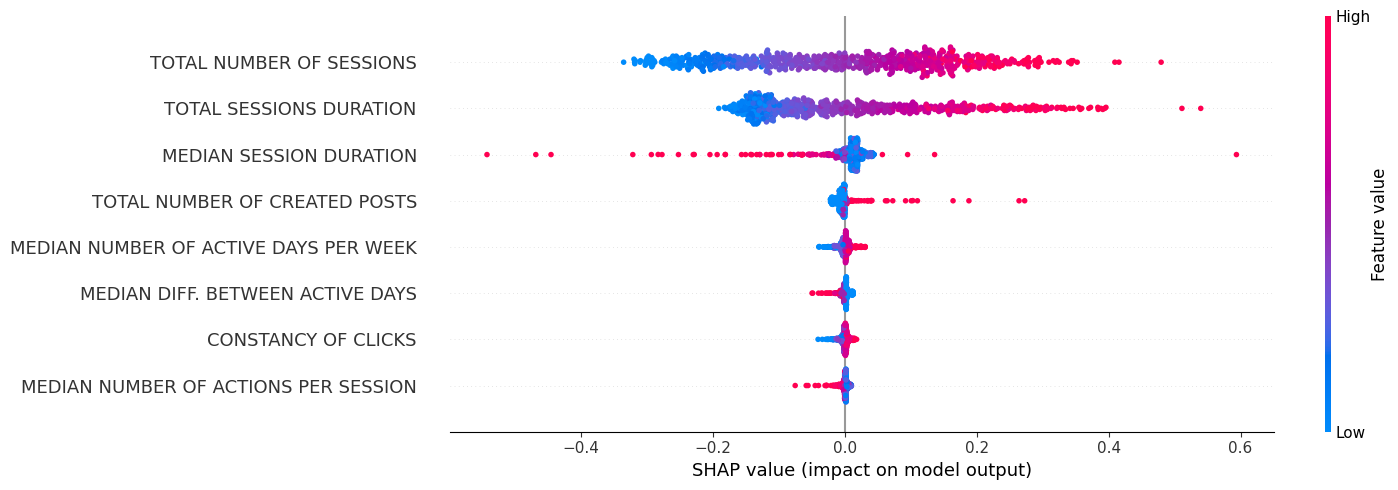

In [33]:
shap.summary_plot(pd.concat(nb_shaps_y1_per_fold.values()).to_numpy(),
                   pd.DataFrame(X_y1, columns= independent_features).reindex([item for row in nb_test_index_y1 for item in row]),
                     plot_size = (15,5), max_display =8)

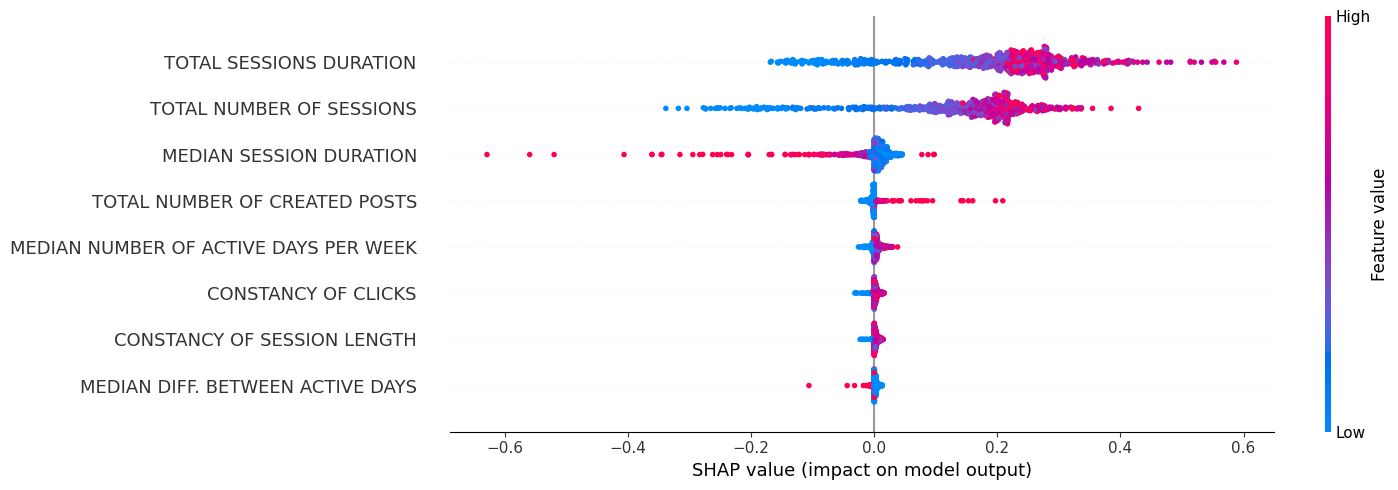

In [35]:
shap.summary_plot(pd.concat(nb_shaps_y2_per_fold.values()).to_numpy(),
                   pd.DataFrame(X_y2, columns= independent_features).reindex([item for row in nb_test_index_y2 for item in row]),
                     plot_size = (15,5), max_display = 8)

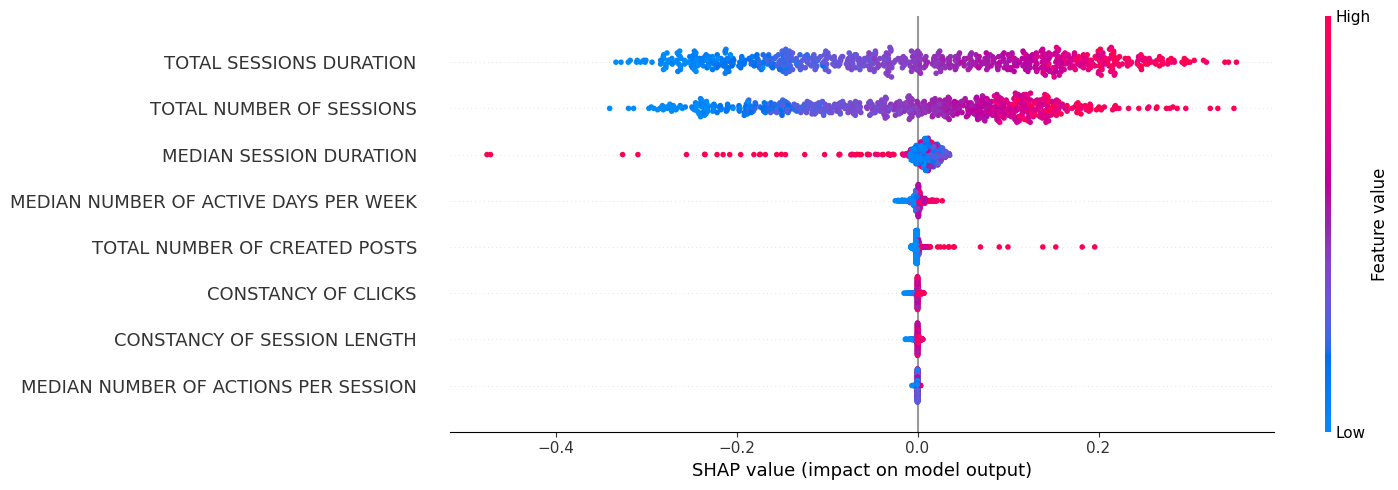

In [36]:
shap.summary_plot(pd.concat(nb_shaps_y2_retrained_per_fold.values()).to_numpy(),
                   pd.DataFrame(X_y2, columns= independent_features).reindex([item for row in nb_test_index_y2 for item in row]),
                     plot_size = (15,5), max_display = 8)

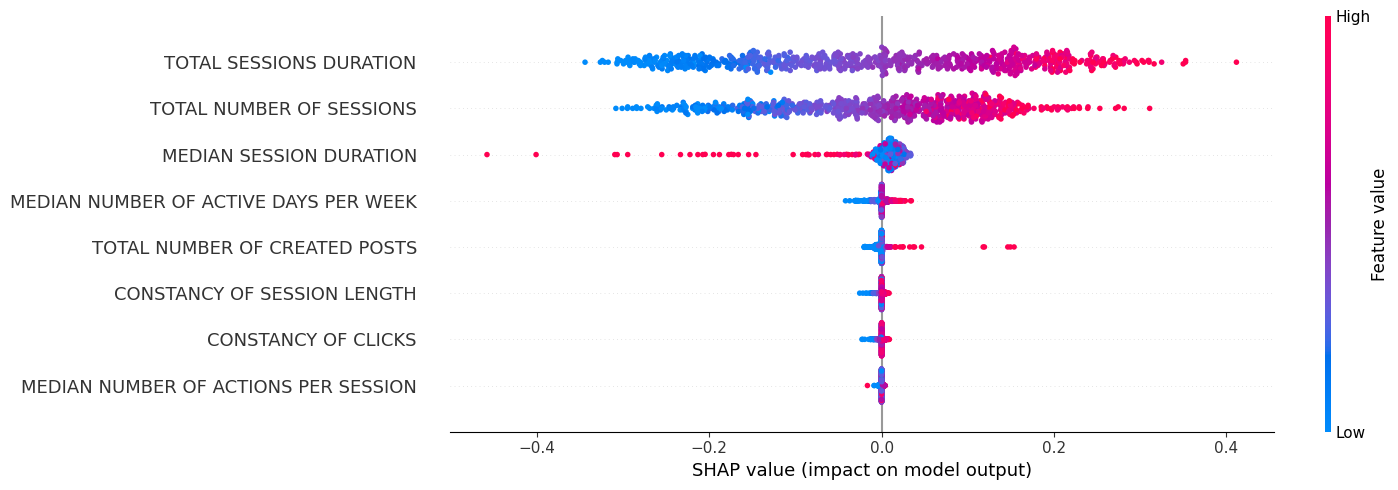

In [37]:
shap.summary_plot(pd.concat(nb_shaps_y2_cv_per_fold.values()).to_numpy(),
                   pd.DataFrame(X_y2, columns= independent_features).reindex([item for row in nb_test_index_y2 for item in row]),
                     plot_size = (15,5), max_display = 8)